In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [18]:
model = tf.keras.Sequential([
                             tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x: x * 100)
])


model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
    metrics=["mae"]
)

def scheduler(epoch, lr):
  return 1e-8 * 10 ** (epoch/20)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    dataset, 
    epochs=100,
    callbacks=[lr_scheduler_callback],
    verbose=1
)

Epoch 1/100
31/31 [==============================] - 8s 27ms/step - loss: 49.3913 - mae: 49.8910
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 48.7253 - mae: 49.2249
Epoch 3/100
31/31 [==============================] - 1s 26ms/step - loss: 47.9181 - mae: 48.4178
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 46.9908 - mae: 47.4904
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 45.9307 - mae: 46.4303
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 44.6934 - mae: 45.1931
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 43.2504 - mae: 43.7504
Epoch 8/100
31/31 [==============================] - 1s 27ms/step - loss: 41.5623 - mae: 42.0619
Epoch 9/100
31/31 [==============================] - 1s 26ms/step - loss: 39.6146 - mae: 40.1136
Epoch 10/100
31/31 [==============================] - 1s 26ms/step - loss: 37.4186 - mae: 37.9184
Epoch 11/100
31/31 [=========

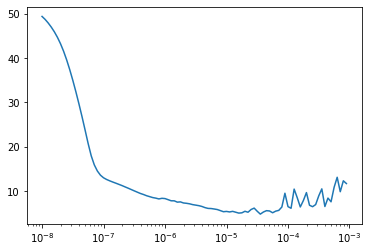

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])

(1e-08, 0.0001, 0.0, 20.0)

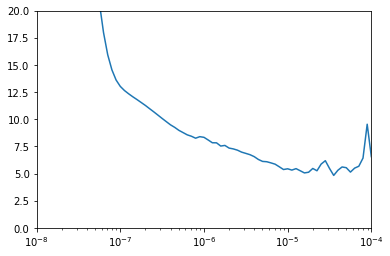

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 20])

In [34]:
model = tf.keras.Sequential([
                             tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x: x * 100)
])


model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics=["mae"]
)

history = model.fit(
    dataset, 
    epochs=500,
    verbose=1
)

Epoch 1/500
31/31 [==============================] - 8s 27ms/step - loss: 12.9044 - mae: 13.3964
Epoch 2/500
31/31 [==============================] - 1s 24ms/step - loss: 6.4850 - mae: 6.9624
Epoch 3/500
31/31 [==============================] - 1s 23ms/step - loss: 5.7847 - mae: 6.2622
Epoch 4/500
31/31 [==============================] - 1s 26ms/step - loss: 5.3512 - mae: 5.8252
Epoch 5/500
31/31 [==============================] - 1s 25ms/step - loss: 5.2958 - mae: 5.7781
Epoch 6/500
31/31 [==============================] - 1s 25ms/step - loss: 5.1723 - mae: 5.6512
Epoch 7/500
31/31 [==============================] - 1s 25ms/step - loss: 4.9338 - mae: 5.4129
Epoch 8/500
31/31 [==============================] - 1s 27ms/step - loss: 4.9091 - mae: 5.3862
Epoch 9/500
31/31 [==============================] - 1s 24ms/step - loss: 4.9404 - mae: 5.4180
Epoch 10/500
31/31 [==============================] - 1s 25ms/step - loss: 4.7352 - mae: 5.2102
Epoch 11/500
31/31 [===========================

In [37]:
forecast = []
for index in range(split_time, len(series)):
  forecast.append(model.predict(series[index-window_size: index][np.newaxis])[0][0])

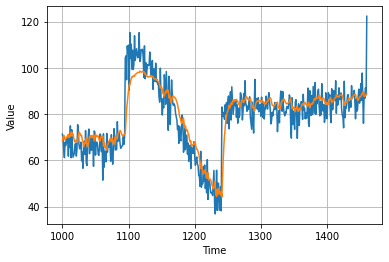

In [38]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)